## Installing the required libraries

In [2]:
#Installing required libraries
# %pip install transformers datasets evaluate accelerate matplotlib absl-py rouge_score --quiet
# %pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

## Importing required libraries and functions

In [3]:
from datasets import load_dataset, load_metric
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
from transformers import pipeline, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

from transformers import logging
import warnings
warnings.filterwarnings("ignore")
logging.set_verbosity_warning()

rouge = evaluate.load('rouge')

plt.rcParams['figure.figsize'] = [20, 6]

/opt/homebrew/anaconda3/envs/NLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading SAMSum dataset

In [4]:
df = load_dataset("samsum")

## Checking for null values

In [5]:
train_df = pd.DataFrame(df['train'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14732 non-null  object
 1   dialogue  14732 non-null  object
 2   summary   14732 non-null  object
dtypes: object(3)
memory usage: 345.4+ KB


## Checking sample input/output

In [6]:
print(f"Input text: \n{train_df.iloc[0]['dialogue']}")
print("-------------------------")
print(f"Output text: \n{train_df.iloc[0]['summary']}")

Input text: 
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
-------------------------
Output text: 
Amanda baked cookies and will bring Jerry some tomorrow.


## Creating dataframe to see input size vs output (summary) size

In [7]:
trainDist = pd.DataFrame()

dialogueLen = []
summaryLen = []
for row in range(len(train_df['dialogue'])):
    dialogueLen.append(len(train_df.iloc[row]['dialogue']))
    summaryLen.append(len(train_df.iloc[row]['summary']))

trainDist['rawLength'] = dialogueLen
trainDist['summaryLength'] = summaryLen

In [8]:
trainDist = trainDist[trainDist['rawLength']>0]

In [9]:
trainDist['lenRatio'] = trainDist['summaryLength']/trainDist['rawLength']
print(f"Mean ratio of summary to dialogue: {trainDist['lenRatio'].mean()}")

Mean ratio of summary to dialogue: 0.290316633016083


In [10]:
trainDist.head()

,rawLength,summaryLength,lenRatio
0,94,56,0.595745
1,111,61,0.549550
2,528,77,0.145833
3,155,97,0.625806
4,909,145,0.159516


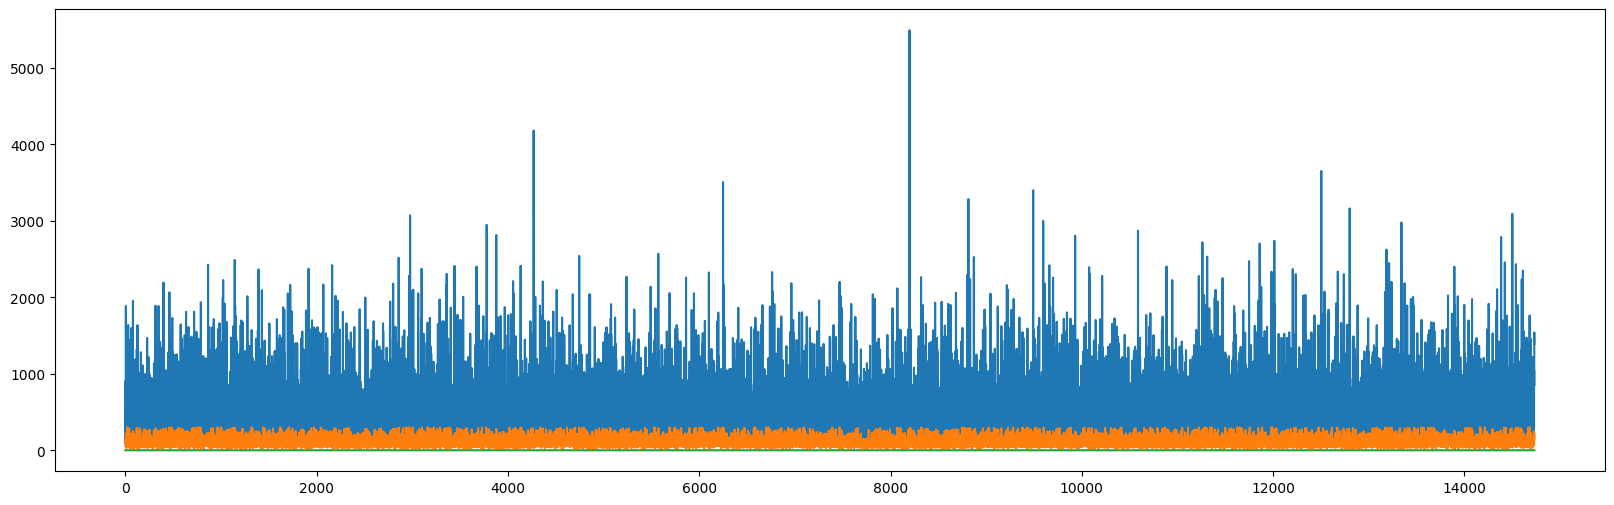

In [11]:
plt.plot(trainDist)

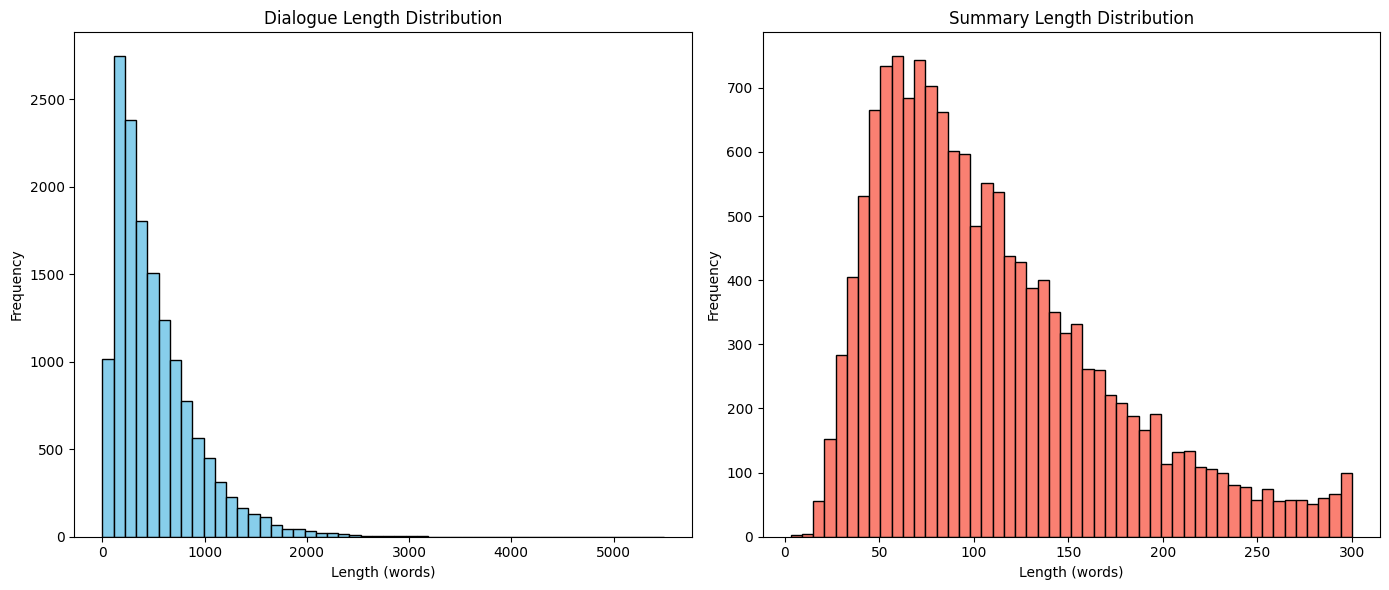

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(dialogueLen, bins=50, color='skyblue', edgecolor='black')
plt.title('Dialogue Length Distribution')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')

# Plotting the length distribution of summaries
plt.subplot(1, 2, 2)
plt.hist(summaryLen, bins=50, color='salmon', edgecolor='black')
plt.title('Summary Length Distribution')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Inference - 
We can see that the summaries do lie in a certain range of length, showcasing that there must a limit set for maximum length of a summary. From the input data, we can see that there are certain input conversations that are very long, and the set limit of summary might not capture the whole conversation.

## Trying pre-trained models to check outputs on sample input

In [12]:
dfResults = pd.DataFrame()

In [13]:
sample_input = train_df.iloc[696]['dialogue']
sample_output = train_df.iloc[696]['summary']

print(sample_input)
print("\n-----------------------------------\n")
print(sample_output)

Anna: I am gonna kill Tom today.
Lisa: What happened?
Anna: Can you imagine that he hasn't changed the baby's diaper for the whole day?
Lisa: Dear lord, no.
Anna: Yes. the smell, the view when I finally changed Stevie - priceless
Lisa: Did you say something?
Anna: Yes, I said: Are you fucking kidding me? Are you a complete idiot?
Lisa: And...?
Anna: He said that a little pee never hurt anybody and that I'm overreacting
Lisa: Typical. Has he ever admitted that he screwed up?
Anna: I honestly can't remember the last time he apologized to me. And it's getting really tiring, you know.
Lisa: I know, would you like Sam to talk to him? You know I can stir him into the right direction, he could really make him think
Anna: I don't know... He's only gonna get mad.
Lisa: At Sam?
Anna: At me.
Lisa: Oh, I see. Maybe you should try to talk to him, but like serious for once, not just in regards to you know, some one thing he messed up, but his general attitude.
Anna: I know I should, but I am just so

## Falcon Text Summarization Model
https://huggingface.co/Falconsai/text_summarization

Model Card: Fine-Tuned T5 Small for Text Summarization
Model Description
The Fine-Tuned T5 Small is a variant of the T5 transformer model, designed for the task of text summarization. It is adapted and fine-tuned to generate concise and coherent summaries of input text.

The model, named "t5-small," is pre-trained on a diverse corpus of text data, enabling it to capture essential information and generate meaningful summaries. Fine-tuning is conducted with careful attention to hyperparameter settings, including batch size and learning rate, to ensure optimal performance for text summarization.

During the fine-tuning process, a batch size of 8 is chosen for efficient computation and learning. Additionally, a learning rate of 2e-5 is selected to balance convergence speed and model optimization. This approach guarantees not only rapid learning but also continuous refinement during training.

The fine-tuning dataset consists of a variety of documents and their corresponding human-generated summaries. This diverse dataset allows the model to learn the art of creating summaries that capture the most important information while maintaining coherence and fluency.

The goal of this meticulous training process is to equip the model with the ability to generate high-quality text summaries, making it valuable for a wide range of applications involving document summarization and content condensation.

Intended Uses & Limitations
Intended Uses
Text Summarization: The primary intended use of this model is to generate concise and coherent text summaries. It is well-suited for applications that involve summarizing lengthy documents, news articles, and textual content.

In [14]:
FalconAIModel = pipeline(task='summarization', model='Falconsai/text_summarization')
FAIsummary = FalconAIModel(sample_input, max_length=300)

In [15]:
print(f"Reference output: {sample_output}\n")
print(f"Predicted output of model: {FAIsummary[0]['summary_text']}")

Reference output: Anna is angry as Tom hasn't changed Stevie's diaper for the whole day. Lisa thinks Anna should talk to Tom about his general attitude. Lisa and Anna want to go to a Spa for a day at the weekend. Lisa suggests leaving Stevie with Anna's sister. Lisa will call the Dream Spa today. 

Predicted output of model: Anna: Yes, I said: Are you fucking kidding me? Anna: I honestly can't remember the last time he apologized to me . Anna: You know I can stir him into the right direction, but like serious for once, some one thing he messed up, but his general attitude . I know I should, but I am just so tired all the time, I get mad and then I just let it go .


In [16]:
#Checking rogue scores for falconAI-model
rouge.compute(predictions=[FAIsummary[0]['summary_text']], references=[sample_output])

{'rouge1': 0.23622047244094488,
 'rouge2': 0.032,
 'rougeL': 0.14173228346456693,
 'rougeLsum': 0.14173228346456693}

## Google's t5-large model
https://huggingface.co/google/flan-t5-large#model-card-for-flan-t5-large

In [17]:
t5Model = pipeline(task='summarization', model='google/flan-t5-large')
t5summary = t5Model(sample_input, max_length=300)

In [18]:
print(f"Reference output: {sample_output}\n")
print(f"Predicted output of model: {t5summary[0]['summary_text']}")

Reference output: Anna is angry as Tom hasn't changed Stevie's diaper for the whole day. Lisa thinks Anna should talk to Tom about his general attitude. Lisa and Anna want to go to a Spa for a day at the weekend. Lisa suggests leaving Stevie with Anna's sister. Lisa will call the Dream Spa today. 

Predicted output of model: Anna is angry with Tom because he didn't change the baby's diaper for the whole day. Lisa will call the Dream SPA later today to book a massage and a facial for Anna.


In [19]:
rouge.compute(predictions=[t5summary[0]['summary_text']], references=[sample_output])

{'rouge1': 0.5714285714285714,
 'rouge2': 0.29213483146067415,
 'rougeL': 0.3956043956043956,
 'rougeLsum': 0.3956043956043956}

## Facebook's Bart-Large-CNN
https://huggingface.co/facebook/bart-large-cnn

BART (large-sized model), fine-tuned on CNN Daily Mail
BART model pre-trained on English language, and fine-tuned on CNN Daily Mail. It was introduced in the paper BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension by Lewis et al. and first released in [this repository (https://github.com/pytorch/fairseq/tree/master/examples/bart).

Disclaimer: The team releasing BART did not write a model card for this model so this model card has been written by the Hugging Face team.

Model description
BART is a transformer encoder-encoder (seq2seq) model with a bidirectional (BERT-like) encoder and an autoregressive (GPT-like) decoder. BART is pre-trained by (1) corrupting text with an arbitrary noising function, and (2) learning a model to reconstruct the original text.

BART is particularly effective when fine-tuned for text generation (e.g. summarization, translation) but also works well for comprehension tasks (e.g. text classification, question answering). This particular checkpoint has been fine-tuned on CNN Daily Mail, a large collection of text-summary pairs.


In [20]:
bartModel = pipeline(task='summarization', model='facebook/bart-large-cnn')
bartSummary = bartModel(sample_input, max_length=300)

In [21]:
print(f"Reference output: {sample_output}\n")
print(f"Predicted output of model: {bartSummary[0]['summary_text']}")

Reference output: Anna is angry as Tom hasn't changed Stevie's diaper for the whole day. Lisa thinks Anna should talk to Tom about his general attitude. Lisa and Anna want to go to a Spa for a day at the weekend. Lisa suggests leaving Stevie with Anna's sister. Lisa will call the Dream Spa today. 

Predicted output of model: Anna: I honestly can't remember the last time he apologized to me. Sam: Maybe you should try to talk to him, but like serious for once, not just in regards to some one thing he messed up. Anna: I am just so tired all the time, I get mad and then I just let it go.


In [22]:
rouge.compute(predictions=[bartSummary[0]['summary_text']], references=[sample_output])

{'rouge1': 0.23008849557522124,
 'rouge2': 0.018018018018018014,
 'rougeL': 0.1592920353982301,
 'rougeLsum': 0.1592920353982301}

## Fine-tuning facebook's bart-large-cnn

In [23]:
# import torch
# torch.cuda.get_device_properties(0)

# max_input = 512
# max_target = 128
# batch_size = 3


# model_checkpoints = "facebook/bart-large-xsum"
# data = load_dataset("samsum")

# tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)
# compute_rouge = load_metric("rouge")

In [24]:
# def data_preprocess(processData):
#   #get all the dialogues
#   inputs = [dialogue for dialogue in processData['dialogue']]
#   #tokenize the dialogues
#   model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)
#   with tokenizer.as_target_tokenizer():
#     targets = tokenizer(processData['summary'], max_length=max_target, padding='max_length', truncation=True)
    
#   #set labels
#   model_inputs['labels'] = targets['input_ids']
#   #return the tokenized data
#   #input_ids, attention_mask and labels
#   return model_inputs

# tokenized_data = data.map(data_preprocess, batched=True)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)
# collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [25]:
# args = Seq2SeqTrainingArguments(
#     'conversation-summ', #save directory
#     overwrite_output_dir=True,
#     evaluation_strategy='epoch',
#     learning_rate=2e-5,
#     per_device_train_batch_size=1,
#     per_device_eval_batch_size= 1,
#     gradient_accumulation_steps=16,
#     weight_decay=0.01,
#     save_total_limit=1,
#     save_only_model = True,
#     num_train_epochs=3,
#     predict_with_generate=True,
#     eval_accumulation_steps=1,
#     fp16=True #available only with CUDA
#     )

# trainer = Seq2SeqTrainer(
#     model, 
#     args,
#     train_dataset=tokenized_data['train'],
#     eval_dataset=tokenized_data['validation'],
#     data_collator=collator,
#     tokenizer=tokenizer,
# )

In [26]:
# trainer.train()

In [27]:
# conversation = """
# Rann: Hey Harry, how have you been? Long time no see!
# Harry: Hey! What a surprise! 
# Harry: Yes, you are right, we haven’t seen each other in a long time. How have you been?
# Rann: There is an important campaign next week which is keeping me busy otherwise rest is going good in my life. 
# Rann: How about you?
# Harry: Oh! I just finished a meeting with a very important client of mine and now I finally have some free time. I feel relieved that I’m done with it.
# Rann: Good for you then. Hey! Let’s make a plan and catch up with each other after next week. 
# Rann: What do you say?
# Harry: Sure, why not? Give me a call when you are done with your project.
# Rann: Sure, then. 
# Rann: Bye, take care.
# Harry: Bye buddy.
# """
# #tokenize the conversation
# model_inputs = tokenizer(conversation,  max_length=max_input, padding='max_length', truncation=True)
# #make prediction
# raw_pred, _, _ = trainer.predict([model_inputs])
# #decode the output
# print(tokenizer.decode(raw_pred[0]))

# trainer.save_model("./finetunedModel")

## Testing Fine-Tuned Model

In [41]:
modelCheckpoints = "finetunedModel/"
fineTunedSummarizer = pipeline("summarization", model=modelCheckpoints)

In [42]:
fineTunedSummary = fineTunedSummarizer(sample_input, max_length=300)

In [43]:
print(f"Reference output: {sample_output}\n")
print(f"Predicted output of model: {fineTunedSummary[0]['summary_text']}")

Reference output: Anna is angry as Tom hasn't changed Stevie's diaper for the whole day. Lisa thinks Anna should talk to Tom about his general attitude. Lisa and Anna want to go to a Spa for a day at the weekend. Lisa suggests leaving Stevie with Anna's sister. Lisa will call the Dream Spa today. 

Predicted output of model: Tom hasn't changed Stevie's diaper for the whole day. Anna is mad at him. Lisa will call the Dream Spa later today. Lisa and Anna will leave Stevie with Anna's sister and go there for a day during the weekend.


In [44]:
rouge.compute(predictions=[fineTunedSummary[0]['summary_text']], references=[sample_output])

{'rouge1': 0.7070707070707071,
 'rouge2': 0.5154639175257733,
 'rougeL': 0.42424242424242425,
 'rougeLsum': 0.42424242424242425}

## Checking and comparing rogue scores of all models
We can see below, the fine-tuned model is performing drastically better than all other models. This is because the model is now trained to summarize coversations which is not in the dataset used to train the pre-trained models

## Generating random test dataset

In [45]:
import random

inputs = df['test']['dialogue']
outputs = df['test']['summary']

random_indices = random.sample(range(0, len(inputs) - 1), 250)
slicedInputs = [inputs[index] for index in random_indices]
referenceOutputs = [outputs[index] for index in random_indices]

In [46]:
def summaryGenerator(model, modelInputs):
    summaryGenerated = model(modelInputs)
    return [ans['summary_text'] for ans in summaryGenerated]

In [50]:
# FAIresults = summaryGenerator(FalconAIModel, slicedInputs)
# googleT5 = summaryGenerator(t5Model, slicedInputs)
# bartFB = summaryGenerator(bartModel, slicedInputs)
# fineTunedResults = summaryGenerator(fineTunedSummarizer, slicedInputs)

In [48]:
dfResults['FAIModel'] = rouge.compute(predictions=FAIresults, references=referenceOutputs)
dfResults['googleT5'] = rouge.compute(predictions=googleT5, references=referenceOutputs)
dfResults['bartFB'] = rouge.compute(predictions=bartFB, references=referenceOutputs)
dfResults['fineTunedModel'] = rouge.compute(predictions=fineTunedResults, references=referenceOutputs)

## Rouge scores of all models

In [49]:
print(dfResults)

           FAIModel  googleT5    bartFB  fineTunedModel
rouge1     0.293357  0.471516  0.300304        0.523027
rouge2     0.085484  0.240905  0.106826        0.286219
rougeL     0.222210  0.398962  0.226886        0.435865
rougeLsum  0.222767  0.399145  0.226734        0.436695
